In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
data_path = ("D:\\资料\\进行中\\实训\\") 
#读取数据
age_train = pd.read_csv(data_path + "age_train.csv", names=['uid','age_group'])
age_test = pd.read_csv(data_path + "age_test.csv", names=['uid'])

#用户标识，性别，常住地，手机型号，手机ram容量，ram剩余容量占比，rom容量，rom剩余容量占比，手机颜色，字体大小，上网类型，移动运营商，手机系统版本
user_basic_info = pd.read_csv(data_path + "user_basic_info.csv", names=['uid','gender','city','prodName','ramCapacity','ramLeftRation','romCapacity','romLeftRation','color','fontSize','ct','carrier','os'])

#用户标识，开机次数，手机ABCDEFG特性使用次数
user_behavior_info = pd.read_csv(data_path + "user_behavior_info.csv", names=['uid','bootTimes','AFuncTimes','BFuncTimes','CFuncTimes','DFuncTimes','EFuncTimes','FFuncTimes','FFuncSum'])

user_app_actived = pd.read_csv(data_path + "user_app_actived.csv", names=['uid','appId'])
#user_app_usage = pd.read_csv("user_app_usage.csv")

#应用标识，应用类型
app_info = pd.read_csv(data_path + "app_info.csv", names=['appId', 'category'])

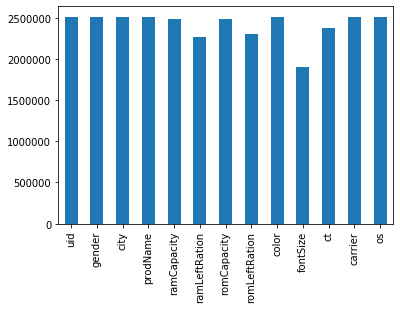

In [4]:
user_basic_info.count().plot(kind = 'bar')

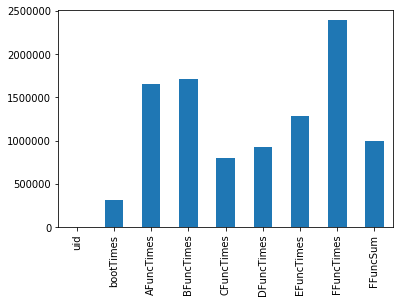

In [10]:
user_behavior_info[user_behavior_info == 0].count().plot(kind = 'bar')

In [46]:
#处理数据量较大的user_app_usage.csv，结合app_info.csv简单统计得到appuseProcessed.csv作为特征
def f(x):
    s = x.value_counts()
    return np.nan if len(s) == 0 else s.index[0]
def processUserAppUsage():
    resTable = pd.DataFrame()
    
    #用户标识，应用标识，使用时长，打开次数，使用日期
    reader = pd.read_csv(data_path + "user_app_usage.csv", names=['uid','appId','duration','times','use_date'], iterator=True)
    last_df = pd.DataFrame()
    #将app类型转换成一个可以处理的数值类型
    app_info = pd.read_csv(data_path + "app_info.csv", names=['appId','category'])
    cats = list(set(app_info['category']))
    category2id = dict(zip(sorted(cats), range(0,len(cats))))
    id2category = dict(zip(range(0,len(cats)), sorted(cats)))
    app_info['category'] = app_info['category'].apply(lambda x: category2id[x])
    i = 1
    
    while True:
        try:
            print("index: {}".format(i))
            i+=1
            df = reader.get_chunk(1000000)
            df = pd.concat([last_df, df])
            idx = df.shape[0]-1
            last_user = df.iat[idx,0]
            while(df.iat[idx,0]==last_user):
                idx-=1
            last_df = df[idx+1:]
            df = df[:idx+1]

            now_df = pd.DataFrame()
            now_df['uid'] = df['uid'].unique()
            now_df = now_df.merge(df.groupby('uid')['appId'].count().to_frame(), how='left', on='uid')
            now_df = now_df.merge(df.groupby('uid')['appId','use_date'].agg(['nunique']), how='left', on='uid')
            now_df = now_df.merge(df.groupby('uid')['duration','times'].agg(['mean','max','std']), how='left', on='uid')    

            #用户标识，记录总数，app总数，日期总数，平均使用时长，最大使用时长，使用时长标准差，平均使用次数，最大使用次数，使用次数标准差
            now_df.columns = ['uid','usage_cnt','usage_appid_cnt','usage_date_cnt','duration_mean','duration_max','duration_std','times_mean','times_max','times_std']


            df = df.merge(app_info, how='left', on='appId')
            now_df = now_df.merge(df.groupby('uid')['category'].nunique().to_frame(), how='left', on='uid')
            #print(df.groupby(['uid'])['category'].value_counts().index[0])
            now_df['usage_most_used_category'] = df.groupby(['uid'])['category'].transform(f)
            resTable = pd.concat([resTable, now_df])
        except StopIteration:
            break
    
    resTable.to_csv(data_path + "appuseProcessed.csv",index=0)
    
    print("Iterator is stopped")

In [4]:
#把category列中的字符值编码成可以训练是数值类型
app_info = pd.read_csv(data_path + "app_info.csv", names=['appId','category'])
cats = list(set(app_info['category']))
category2id = dict(zip(sorted(cats), range(0,len(cats))))
id2category = dict(zip(range(0,len(cats)), sorted(cats)))
app_info['category'] = app_info['category'].apply(lambda x: category2id[x])
#生成一个关于appId的category字典
app_dict = app_info.groupby('appId')['category'].apply(list)
#len(app_dict['a006'])
#app_dict['a006'][1]

In [9]:
#统计每个用户激活的app类型的次数
user_app_ca = pd.DataFrame()
user_app_ca['uid'] = user_app_actived['uid']
for num in range(0,40):
    user_app_ca[num] = 0
i = 0
#app_id_num = np.array(app_info['appId'])
for x in user_app_actived['appId']: #忽略某个app不在app_info里的个例
    for y in x.split('#'):
        if(y not in app_dict):
            continue
        #print('0')
        temp = app_dict[y]
        for j in range(len(temp)):
            user_app_ca.iat[i,1+temp[j]] +=  1
    i = i + 1
    if(i % 10000 == 0):
        print(i)
    
user_app_ca

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
1390

,uid,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,1000008,0,0,0,0,0,0,0,12,2,6,0,0,0,0,5,0,0,13,5,0,5,1,1,0,0,0,2,0,0,7,0,0,0,1,0,0,0,8,1,6
1,1000010,0,0,0,0,0,0,0,15,0,11,0,0,0,0,1,0,0,16,6,3,4,4,4,0,0,0,0,0,0,4,0,0,0,0,0,0,0,7,2,3
2,1000011,0,0,0,0,1,0,0,4,0,0,0,1,0,0,0,0,0,6,5,0,1,2,0,0,0,0,0,0,0,3,0,1,0,0,0,1,0,3,0,0
3,1000013,0,0,0,0,0,0,0,11,0,7,0,0,0,0,2,0,0,13,5,0,3,3,3,0,0,0,0,0,0,5,0,0,0,0,0,0,0,7,2,5
4,1000014,0,0,0,0,0,0,0,15,0,4,0,0,0,0,1,0,0,25,10,0,10,5,2,0,0,0,1,0,0,6,0,0,0,0,0,0,0,6,0,4
5,1000016,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,9,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,9
6,1000021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,2,1,3,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
7,1000022,0,0,0,0,1,0,0,23,0,9,0,0,0,0,2,0,0,30,11,1,3,7,5,0,0,0,5,0,0,7,0,0,0,0,0,0,0,9,1,8
8,1000036,0,0,0,0,0,0,0,18,0,5,0,0,0,0,3,0,0,30,7,1,6,4,2,0,0,0,0,0,0,7,0,0,0,2,0,0,0,13,0,12
9,1000047,0,0,0,0,0,0,0,4,0,1,0,0,0,0,2,0,0,10,6,0,6,1,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,1,0,0


In [5]:
user_app_ca = pd.read_csv(data_path + "user_app_ca.csv")

In [6]:
#将user_basic_info.csv 和 user_behavior_info.csv中的字符值编码成可以训练的数值类型，合并
class2id = {}
id2class = {}
def mergeBasicTables(baseTable):
    resTable = baseTable.merge(user_basic_info, how='left', on='uid', suffixes=('_base0', '_ubaf'))
    resTable = resTable.merge(user_behavior_info, how='left', on='uid', suffixes=('_base1', '_ubef'))
    cat_columns = ['city','prodName','color','carrier','os','ct']
    for c in cat_columns:
        resTable[c] = resTable[c].apply(lambda x: x if type(x)==str else str(x))
        sort_temp = sorted(list(set(resTable[c])))  
        class2id[c+'2id'] = dict(zip(sort_temp, range(1, len(sort_temp)+1)))
        id2class['id2'+c] = dict(zip(range(1,len(sort_temp)+1), sort_temp))
        resTable[c] = resTable[c].apply(lambda x: class2id[c+'2id'][x])
        
    return resTable

In [7]:
#处理app使用相关数据
#对user_app_actived.csv简单统计
#将之前训练的appuseProcess.csv进行合并
def mergeAppData(baseTable):
    resTable = baseTable.merge(user_app_actived, how='left', on='uid')
    resTable['appId'] = resTable['appId'].apply(lambda x: len(list(x.split('#'))))
    appusedTable = pd.read_csv(data_path + "appuseProcessed.csv")
    resTable = resTable.merge(appusedTable, how='left', on='uid')
    resTable[['category', 'usage_most_used_category']] = resTable[['category', 'usage_most_used_category']].fillna(41)
    resTable = resTable.fillna(0)
    #print(resTable[:5])
    #加入使用时长和开机次数之比为特征
    resTable.eval('bootTime_duration = duration_mean / (bootTimes+1)' , inplace = True)
    resTable = resTable.merge(user_app_ca, how='left', on='uid')
    return resTable

In [8]:
#合并用户基本特征以及app使用相关特征，作为训练集和测试集
df_train = mergeAppData(mergeBasicTables(age_train))
df_test = mergeAppData(mergeBasicTables(age_test))
print(df_train.shape)
print(df_test.shape)

(2010000, 75)
(502500, 74)


In [9]:
#训练模型

from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.preprocessing import Imputer
from sklearn.ensemble import ExtraTreesClassifier

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

In [10]:
print("训练模型：")
param = {
        'learning_rate': 0.1,
        'lambda_l1': 0.1,
        'lambda_l2': 0.2,
        'max_depth': 20,
        'objective': 'multiclass',
        'num_class': 7,
        'num_leaves': 31,
        'min_data_in_leaf': 50,
        'max_bin': 230,
        'feature_fraction': 0.8,
        'metric': 'multi_error'
        }

X = df_train.drop(['age_group','uid'], axis=1)
y = df_train['age_group']
uid = df_test['uid']
test = df_test.drop('uid', axis=1)

xx_score = []
cv_pred = []
skf = StratifiedKFold(n_splits=3, random_state=1030, shuffle=True)
for index, (train_index, vali_index) in enumerate(skf.split(X, y)):
    print(index)
    x_train, y_train, x_vali, y_vali = np.array(X)[train_index], np.array(y)[train_index], np.array(X)[vali_index], np.array(y)[vali_index]
    train = lgb.Dataset(x_train, y_train)
    vali =lgb.Dataset(x_vali, y_vali)
    print("training start...")
    model = lgb.train(param, train, num_boost_round=1000, valid_sets=[vali], early_stopping_rounds=50)
    xx_pred = model.predict(x_vali,num_iteration=model.best_iteration)
    xx_pred = [np.argmax(x) for x in xx_pred]
    xx_score.append(f1_score(y_vali,xx_pred,average='weighted'))
    y_test = model.predict(test,num_iteration=model.best_iteration)
    y_test = [np.argmax(x) for x in y_test]
    if index == 0:
        cv_pred = np.array(y_test).reshape(-1, 1)
    else:
        cv_pred = np.hstack((cv_pred, np.array(y_test).reshape(-1, 1)))
        
submit = []
for line in cv_pred:
    submit.append(np.argmax(np.bincount(line)))
df = pd.DataFrame({'id':uid.as_matrix(),'label':submit})
df.to_csv(data_path + 'submission.csv',index=False)

训练模型：
0
training start...
[1]	valid_0's multi_error: 0.701493
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's multi_error: 0.696569
[3]	valid_0's multi_error: 0.67383
[4]	valid_0's multi_error: 0.653895
[5]	valid_0's multi_error: 0.63928
[6]	valid_0's multi_error: 0.627129
[7]	valid_0's multi_error: 0.614138
[8]	valid_0's multi_error: 0.602033
[9]	valid_0's multi_error: 0.594802
[10]	valid_0's multi_error: 0.588663
[11]	valid_0's multi_error: 0.583389
[12]	valid_0's multi_error: 0.57929
[13]	valid_0's multi_error: 0.575784
[14]	valid_0's multi_error: 0.572678
[15]	valid_0's multi_error: 0.569266
[16]	valid_0's multi_error: 0.566999
[17]	valid_0's multi_error: 0.564799
[18]	valid_0's multi_error: 0.562659
[19]	valid_0's multi_error: 0.560663
[20]	valid_0's multi_error: 0.559042
[21]	valid_0's multi_error: 0.557228
[22]	valid_0's multi_error: 0.555774
[23]	valid_0's multi_error: 0.554465
[24]	valid_0's multi_error: 0.553225
[25]	valid_0's multi_error: 0.552162

[218]	valid_0's multi_error: 0.497377
[219]	valid_0's multi_error: 0.497326
[220]	valid_0's multi_error: 0.497157
[221]	valid_0's multi_error: 0.497056
[222]	valid_0's multi_error: 0.49702
[223]	valid_0's multi_error: 0.496978
[224]	valid_0's multi_error: 0.49692
[225]	valid_0's multi_error: 0.496871
[226]	valid_0's multi_error: 0.496725
[227]	valid_0's multi_error: 0.49655
[228]	valid_0's multi_error: 0.496504
[229]	valid_0's multi_error: 0.496478
[230]	valid_0's multi_error: 0.496426
[231]	valid_0's multi_error: 0.496298
[232]	valid_0's multi_error: 0.49625
[233]	valid_0's multi_error: 0.496141
[234]	valid_0's multi_error: 0.49606
[235]	valid_0's multi_error: 0.49592
[236]	valid_0's multi_error: 0.495959
[237]	valid_0's multi_error: 0.495872
[238]	valid_0's multi_error: 0.495841
[239]	valid_0's multi_error: 0.495754
[240]	valid_0's multi_error: 0.495735
[241]	valid_0's multi_error: 0.495647
[242]	valid_0's multi_error: 0.495601
[243]	valid_0's multi_error: 0.495523
[244]	valid_0's mu

[435]	valid_0's multi_error: 0.488571
[436]	valid_0's multi_error: 0.488549
[437]	valid_0's multi_error: 0.488538
[438]	valid_0's multi_error: 0.488571
[439]	valid_0's multi_error: 0.48852
[440]	valid_0's multi_error: 0.488501
[441]	valid_0's multi_error: 0.488504
[442]	valid_0's multi_error: 0.488456
[443]	valid_0's multi_error: 0.488414
[444]	valid_0's multi_error: 0.488404
[445]	valid_0's multi_error: 0.488405
[446]	valid_0's multi_error: 0.488417
[447]	valid_0's multi_error: 0.488408
[448]	valid_0's multi_error: 0.488387
[449]	valid_0's multi_error: 0.488378
[450]	valid_0's multi_error: 0.488366
[451]	valid_0's multi_error: 0.488352
[452]	valid_0's multi_error: 0.488353
[453]	valid_0's multi_error: 0.488331
[454]	valid_0's multi_error: 0.488329
[455]	valid_0's multi_error: 0.488322
[456]	valid_0's multi_error: 0.488259
[457]	valid_0's multi_error: 0.488253
[458]	valid_0's multi_error: 0.488226
[459]	valid_0's multi_error: 0.488204
[460]	valid_0's multi_error: 0.488201
[461]	valid_0

[652]	valid_0's multi_error: 0.486072
[653]	valid_0's multi_error: 0.48604
[654]	valid_0's multi_error: 0.485998
[655]	valid_0's multi_error: 0.485968
[656]	valid_0's multi_error: 0.485957
[657]	valid_0's multi_error: 0.485986
[658]	valid_0's multi_error: 0.486008
[659]	valid_0's multi_error: 0.486008
[660]	valid_0's multi_error: 0.485968
[661]	valid_0's multi_error: 0.485974
[662]	valid_0's multi_error: 0.485981
[663]	valid_0's multi_error: 0.485929
[664]	valid_0's multi_error: 0.485902
[665]	valid_0's multi_error: 0.485932
[666]	valid_0's multi_error: 0.485893
[667]	valid_0's multi_error: 0.485868
[668]	valid_0's multi_error: 0.485923
[669]	valid_0's multi_error: 0.485932
[670]	valid_0's multi_error: 0.48595
[671]	valid_0's multi_error: 0.485917
[672]	valid_0's multi_error: 0.485889
[673]	valid_0's multi_error: 0.486002
[674]	valid_0's multi_error: 0.486022
[675]	valid_0's multi_error: 0.486069
[676]	valid_0's multi_error: 0.486041
[677]	valid_0's multi_error: 0.486002
[678]	valid_0'

[869]	valid_0's multi_error: 0.485001
[870]	valid_0's multi_error: 0.48499
[871]	valid_0's multi_error: 0.484995
[872]	valid_0's multi_error: 0.484974
[873]	valid_0's multi_error: 0.484987
[874]	valid_0's multi_error: 0.484981
[875]	valid_0's multi_error: 0.485007
[876]	valid_0's multi_error: 0.485002
[877]	valid_0's multi_error: 0.484972
[878]	valid_0's multi_error: 0.484962
[879]	valid_0's multi_error: 0.484969
[880]	valid_0's multi_error: 0.484952
[881]	valid_0's multi_error: 0.484934
[882]	valid_0's multi_error: 0.484949
[883]	valid_0's multi_error: 0.484934
[884]	valid_0's multi_error: 0.484931
[885]	valid_0's multi_error: 0.484929
[886]	valid_0's multi_error: 0.484886
[887]	valid_0's multi_error: 0.484869
[888]	valid_0's multi_error: 0.484889
[889]	valid_0's multi_error: 0.484874
[890]	valid_0's multi_error: 0.484866
[891]	valid_0's multi_error: 0.484865
[892]	valid_0's multi_error: 0.484837
[893]	valid_0's multi_error: 0.484865
[894]	valid_0's multi_error: 0.484841
[895]	valid_0

[84]	valid_0's multi_error: 0.516361
[85]	valid_0's multi_error: 0.516036
[86]	valid_0's multi_error: 0.515643
[87]	valid_0's multi_error: 0.515479
[88]	valid_0's multi_error: 0.515119
[89]	valid_0's multi_error: 0.51469
[90]	valid_0's multi_error: 0.514442
[91]	valid_0's multi_error: 0.514334
[92]	valid_0's multi_error: 0.513996
[93]	valid_0's multi_error: 0.513793
[94]	valid_0's multi_error: 0.51353
[95]	valid_0's multi_error: 0.513221
[96]	valid_0's multi_error: 0.512969
[97]	valid_0's multi_error: 0.5128
[98]	valid_0's multi_error: 0.512621
[99]	valid_0's multi_error: 0.51239
[100]	valid_0's multi_error: 0.512112
[101]	valid_0's multi_error: 0.511884
[102]	valid_0's multi_error: 0.511575
[103]	valid_0's multi_error: 0.511364
[104]	valid_0's multi_error: 0.511149
[105]	valid_0's multi_error: 0.510893
[106]	valid_0's multi_error: 0.510584
[107]	valid_0's multi_error: 0.510306
[108]	valid_0's multi_error: 0.51016
[109]	valid_0's multi_error: 0.509958
[110]	valid_0's multi_error: 0.509

[301]	valid_0's multi_error: 0.492063
[302]	valid_0's multi_error: 0.492049
[303]	valid_0's multi_error: 0.491955
[304]	valid_0's multi_error: 0.492013
[305]	valid_0's multi_error: 0.491888
[306]	valid_0's multi_error: 0.491945
[307]	valid_0's multi_error: 0.491852
[308]	valid_0's multi_error: 0.491779
[309]	valid_0's multi_error: 0.491749
[310]	valid_0's multi_error: 0.491734
[311]	valid_0's multi_error: 0.491604
[312]	valid_0's multi_error: 0.491649
[313]	valid_0's multi_error: 0.491599
[314]	valid_0's multi_error: 0.491581
[315]	valid_0's multi_error: 0.491585
[316]	valid_0's multi_error: 0.491518
[317]	valid_0's multi_error: 0.491442
[318]	valid_0's multi_error: 0.491379
[319]	valid_0's multi_error: 0.491393
[320]	valid_0's multi_error: 0.491249
[321]	valid_0's multi_error: 0.491201
[322]	valid_0's multi_error: 0.491161
[323]	valid_0's multi_error: 0.491185
[324]	valid_0's multi_error: 0.491137
[325]	valid_0's multi_error: 0.4911
[326]	valid_0's multi_error: 0.491119
[327]	valid_0'

[518]	valid_0's multi_error: 0.486378
[519]	valid_0's multi_error: 0.486273
[520]	valid_0's multi_error: 0.486257
[521]	valid_0's multi_error: 0.486266
[522]	valid_0's multi_error: 0.486219
[523]	valid_0's multi_error: 0.486222
[524]	valid_0's multi_error: 0.486207
[525]	valid_0's multi_error: 0.486172
[526]	valid_0's multi_error: 0.486149
[527]	valid_0's multi_error: 0.486158
[528]	valid_0's multi_error: 0.486182
[529]	valid_0's multi_error: 0.486134
[530]	valid_0's multi_error: 0.486151
[531]	valid_0's multi_error: 0.486076
[532]	valid_0's multi_error: 0.486064
[533]	valid_0's multi_error: 0.48614
[534]	valid_0's multi_error: 0.486057
[535]	valid_0's multi_error: 0.486054
[536]	valid_0's multi_error: 0.486066
[537]	valid_0's multi_error: 0.486037
[538]	valid_0's multi_error: 0.486031
[539]	valid_0's multi_error: 0.486021
[540]	valid_0's multi_error: 0.48601
[541]	valid_0's multi_error: 0.486001
[542]	valid_0's multi_error: 0.485999
[543]	valid_0's multi_error: 0.486015
[544]	valid_0'

[735]	valid_0's multi_error: 0.484394
[736]	valid_0's multi_error: 0.4844
[737]	valid_0's multi_error: 0.4844
[738]	valid_0's multi_error: 0.48436
[739]	valid_0's multi_error: 0.484369
[740]	valid_0's multi_error: 0.48436
[741]	valid_0's multi_error: 0.484358
[742]	valid_0's multi_error: 0.484345
[743]	valid_0's multi_error: 0.484367
[744]	valid_0's multi_error: 0.484343
[745]	valid_0's multi_error: 0.484333
[746]	valid_0's multi_error: 0.484322
[747]	valid_0's multi_error: 0.484294
[748]	valid_0's multi_error: 0.484296
[749]	valid_0's multi_error: 0.484369
[750]	valid_0's multi_error: 0.484381
[751]	valid_0's multi_error: 0.484343
[752]	valid_0's multi_error: 0.484285
[753]	valid_0's multi_error: 0.484248
[754]	valid_0's multi_error: 0.484258
[755]	valid_0's multi_error: 0.484276
[756]	valid_0's multi_error: 0.484236
[757]	valid_0's multi_error: 0.484257
[758]	valid_0's multi_error: 0.484245
[759]	valid_0's multi_error: 0.48424
[760]	valid_0's multi_error: 0.484316
[761]	valid_0's mul

[952]	valid_0's multi_error: 0.48321
[953]	valid_0's multi_error: 0.483216
[954]	valid_0's multi_error: 0.483222
[955]	valid_0's multi_error: 0.483213
[956]	valid_0's multi_error: 0.483239
[957]	valid_0's multi_error: 0.48324
[958]	valid_0's multi_error: 0.483272
[959]	valid_0's multi_error: 0.483242
[960]	valid_0's multi_error: 0.483242
[961]	valid_0's multi_error: 0.483218
[962]	valid_0's multi_error: 0.483234
[963]	valid_0's multi_error: 0.483227
[964]	valid_0's multi_error: 0.483216
[965]	valid_0's multi_error: 0.483222
[966]	valid_0's multi_error: 0.483215
[967]	valid_0's multi_error: 0.483221
[968]	valid_0's multi_error: 0.483215
[969]	valid_0's multi_error: 0.483185
[970]	valid_0's multi_error: 0.483225
[971]	valid_0's multi_error: 0.48321
[972]	valid_0's multi_error: 0.483181
[973]	valid_0's multi_error: 0.483163
[974]	valid_0's multi_error: 0.483155
[975]	valid_0's multi_error: 0.483158
[976]	valid_0's multi_error: 0.48314
[977]	valid_0's multi_error: 0.483172
[978]	valid_0's 

[167]	valid_0's multi_error: 0.503716
[168]	valid_0's multi_error: 0.503517
[169]	valid_0's multi_error: 0.503395
[170]	valid_0's multi_error: 0.50321
[171]	valid_0's multi_error: 0.503086
[172]	valid_0's multi_error: 0.502944
[173]	valid_0's multi_error: 0.502884
[174]	valid_0's multi_error: 0.502808
[175]	valid_0's multi_error: 0.502681
[176]	valid_0's multi_error: 0.502547
[177]	valid_0's multi_error: 0.502517
[178]	valid_0's multi_error: 0.502468
[179]	valid_0's multi_error: 0.502354
[180]	valid_0's multi_error: 0.502178
[181]	valid_0's multi_error: 0.502134
[182]	valid_0's multi_error: 0.502046
[183]	valid_0's multi_error: 0.501904
[184]	valid_0's multi_error: 0.50179
[185]	valid_0's multi_error: 0.501719
[186]	valid_0's multi_error: 0.501657
[187]	valid_0's multi_error: 0.501586
[188]	valid_0's multi_error: 0.501437
[189]	valid_0's multi_error: 0.501347
[190]	valid_0's multi_error: 0.501219
[191]	valid_0's multi_error: 0.501074
[192]	valid_0's multi_error: 0.501086
[193]	valid_0'

[384]	valid_0's multi_error: 0.49099
[385]	valid_0's multi_error: 0.49102
[386]	valid_0's multi_error: 0.491007
[387]	valid_0's multi_error: 0.490946
[388]	valid_0's multi_error: 0.490978
[389]	valid_0's multi_error: 0.490913
[390]	valid_0's multi_error: 0.490844
[391]	valid_0's multi_error: 0.49082
[392]	valid_0's multi_error: 0.490838
[393]	valid_0's multi_error: 0.490798
[394]	valid_0's multi_error: 0.49075
[395]	valid_0's multi_error: 0.490774
[396]	valid_0's multi_error: 0.490731
[397]	valid_0's multi_error: 0.490728
[398]	valid_0's multi_error: 0.490722
[399]	valid_0's multi_error: 0.490644
[400]	valid_0's multi_error: 0.490623
[401]	valid_0's multi_error: 0.490508
[402]	valid_0's multi_error: 0.49054
[403]	valid_0's multi_error: 0.490601
[404]	valid_0's multi_error: 0.490547
[405]	valid_0's multi_error: 0.490511
[406]	valid_0's multi_error: 0.49052
[407]	valid_0's multi_error: 0.490511
[408]	valid_0's multi_error: 0.490453
[409]	valid_0's multi_error: 0.490437
[410]	valid_0's mu

[601]	valid_0's multi_error: 0.487338
[602]	valid_0's multi_error: 0.487348
[603]	valid_0's multi_error: 0.487362
[604]	valid_0's multi_error: 0.48729
[605]	valid_0's multi_error: 0.487286
[606]	valid_0's multi_error: 0.487251
[607]	valid_0's multi_error: 0.487259
[608]	valid_0's multi_error: 0.487247
[609]	valid_0's multi_error: 0.487241
[610]	valid_0's multi_error: 0.487234
[611]	valid_0's multi_error: 0.487213
[612]	valid_0's multi_error: 0.487205
[613]	valid_0's multi_error: 0.487175
[614]	valid_0's multi_error: 0.487144
[615]	valid_0's multi_error: 0.487131
[616]	valid_0's multi_error: 0.48709
[617]	valid_0's multi_error: 0.487068
[618]	valid_0's multi_error: 0.487051
[619]	valid_0's multi_error: 0.487035
[620]	valid_0's multi_error: 0.487013
[621]	valid_0's multi_error: 0.486983
[622]	valid_0's multi_error: 0.486972
[623]	valid_0's multi_error: 0.486981
[624]	valid_0's multi_error: 0.486981
[625]	valid_0's multi_error: 0.486968
[626]	valid_0's multi_error: 0.48702
[627]	valid_0's

[818]	valid_0's multi_error: 0.485734
[819]	valid_0's multi_error: 0.485729
[820]	valid_0's multi_error: 0.485716
[821]	valid_0's multi_error: 0.485704
[822]	valid_0's multi_error: 0.485705
[823]	valid_0's multi_error: 0.485686
[824]	valid_0's multi_error: 0.485738
[825]	valid_0's multi_error: 0.485722
[826]	valid_0's multi_error: 0.485684
[827]	valid_0's multi_error: 0.485638
[828]	valid_0's multi_error: 0.485617
[829]	valid_0's multi_error: 0.485614
[830]	valid_0's multi_error: 0.485635
[831]	valid_0's multi_error: 0.485625
[832]	valid_0's multi_error: 0.485602
[833]	valid_0's multi_error: 0.485602
[834]	valid_0's multi_error: 0.485538
[835]	valid_0's multi_error: 0.485526
[836]	valid_0's multi_error: 0.485508
[837]	valid_0's multi_error: 0.48549
[838]	valid_0's multi_error: 0.48546
[839]	valid_0's multi_error: 0.485505
[840]	valid_0's multi_error: 0.485516
[841]	valid_0's multi_error: 0.485472
[842]	valid_0's multi_error: 0.485447
[843]	valid_0's multi_error: 0.485457
[844]	valid_0'

c:\users\nby\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


,uid,gender,city,prodName,ramCapacity,ramLeftRation,romCapacity,romLeftRation,color,fontSize,ct,carrier,os
0,1000001,0,c00145,p00169,3.0,0.43,32.0,0.46,皓月银,1.15000,4g,China_Mobile,8.0
1,1000002,1,c0043,p0022,NaN,0.26,NaN,0.59,渐变黑,1.00000,wifi,China_Mobile,9.0
2,1000004,1,c00281,p0013,3.0,0.36,32.0,0.09,幻海蓝,1.00000,4g#wifi,China_Mobile,8.0
3,1000006,0,c00359,p0045,2.0,0.19,16.0,0.42,灰色,NaN,NaN,China_Mobile,6.0
4,1000007,1,c006,p0097,6.0,0.20,137.0,0.50,宝石蓝,1.00000,4g#wifi,China_Telecom,9.0
5,1000008,1,c0043,p00155,6.0,0.36,128.0,0.47,草木绿,1.15000,4g#wifi,China_Telecom,8.0
6,1000010,0,c0043,p0029,6.0,0.36,64.0,0.01,铂光金,NaN,4g#wifi,China_Mobile,8.0
7,1000011,0,c00126,p0023,NaN,NaN,NaN,NaN,幻夜黑,NaN,4g#wifi,China_Mobile,8.1
8,1000012,0,c00284,p00169,4.0,0.31,64.0,0.39,琥珀金,1.30001,wifi,China_Mobile,8.0
9,1000015,1,c00306,p00169,3.0,0.34,32.0,0.06,皓月银,1.30000,wifi,China_Telecom,8.0
